In [1]:
import sys
# Hay que ejecutar esta línea antes de importar el módulo.
sys.path.append("C:/Users/Vicen/PycharmProjects/tgpy")
%reload_ext tgpy
import pandas as pd
import tgpy as tg
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.signal import periodogram
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
sb.set_context('notebook', font_scale=1.4)
sb.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)

# Datos a utilizar: Data set Sunspots 1950-2020

In [2]:
Sunspots = pd.read_csv('Sunspots.csv')
Sunspots['year'] = pd.DatetimeIndex(Sunspots['Date']).year
Sunspots_train_anual = Sunspots[['year','Monthly Mean Total Sunspot Number']]  # years of de data set
Sunspots_train = Sunspots_train_anual.groupby("year", as_index=False).mean()
Sunspots_train = Sunspots_train.iloc[51:272]  # train years 
(Sunspots_train).reset_index(inplace=True, drop=True)
Sunspots_train['year'] = Sunspots_train['year']-Sunspots_train['year'].min()

t_anual = Sunspots_train["year"]-Sunspots_train["year"]
y_anual = Sunspots_train["Monthly Mean Total Sunspot Number"]
prop = 0.8
obs = int(prop*len(t_anual))
train_index = list(range(obs)) # conjuto de entrenamiento
valid_index = list(range(obs,len(t_anual))) #conjunto de validacion

# Modelo a analizar con kernel SM + SE

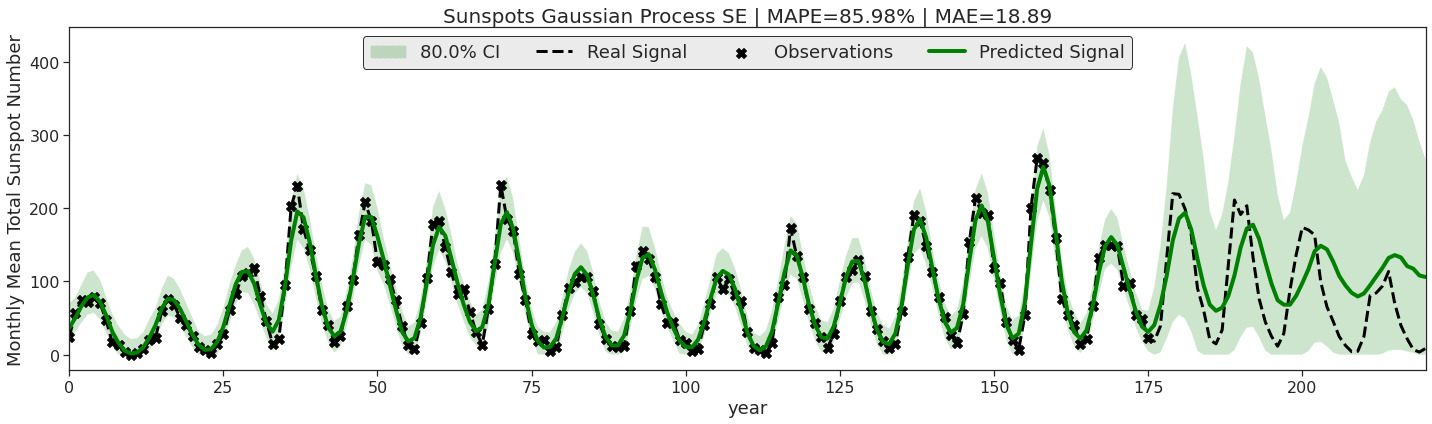

In [3]:
def model_sm_se(df, index_obs, dim = 100): 
    inputs = [df.columns.values[0]]
    outputs = [df.columns.values[1]]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    dt.calculate_scale(inputs=True, outputs=False, quantile=False)
    
    var_sm = tg.TgPriorUnivariate('var_sm', ['var_sm'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance_sm = tg.TgPriorUnivariate('relevance_sm', ['relevance_sm'], dim=dim, low=70, high=80, alpha=2, beta=4) 
    period_sm = tg.TgPriorUnivariate('period_sm', ['period_sm'], dim=dim, low=10, high=12.5, alpha=2, beta=2)
    kernel_sm = tg.SM(var_sm, relevance_sm, period_sm)

    var_se = tg.TgPriorUnivariate('var_se', ['var_se'], dim=dim, low=0.01, high=0.2, alpha=4, beta=2)
    relevance_se = tg.TgPriorUnivariate('relevance_se', ['relevance_se'], dim=dim, low=0, high=10, alpha=2, beta=4) 
    kernel_se = tg.SE(var_se, relevance_se)   
    
    noise = tg.TgPriorUnivariate('noise', ['noise'], dim=dim, low=0.01, high=0.1, alpha=2, beta=4)
    shift = tg.TgPriorUnivariate('shift', ['shift'], dim=dim, low=-1, high=1, alpha=2, beta=4)
    power = tg.TgPriorUnivariate('power', ['power'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    cov = tg.CovarianceTransport(kernel_sm + kernel_se, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    
    tgp.obs(index_obs)
    return tgp

tgp_sm_se = model_sm_se(Sunspots_train, train_index)

tgp_sm_se.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

  0%|                                                                                                         …

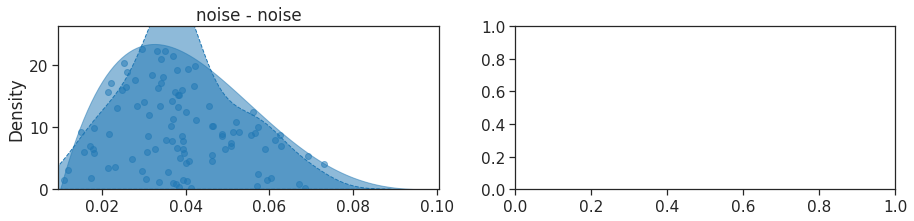

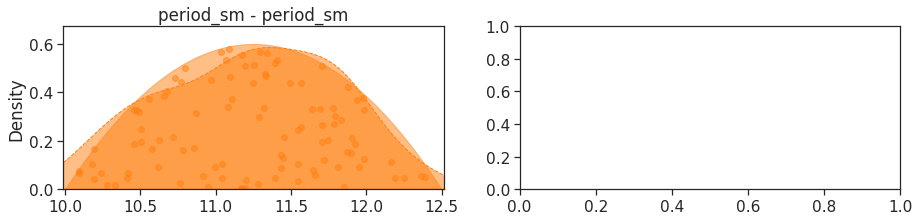

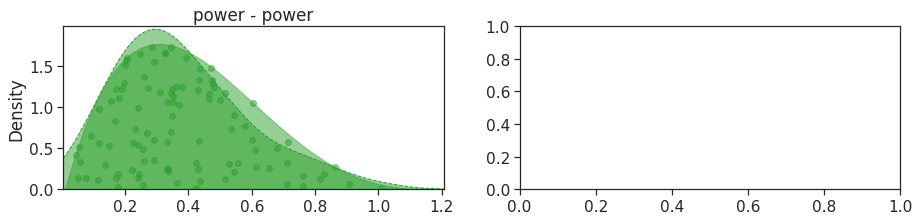

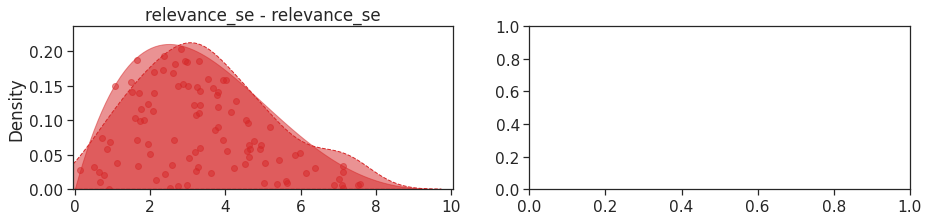

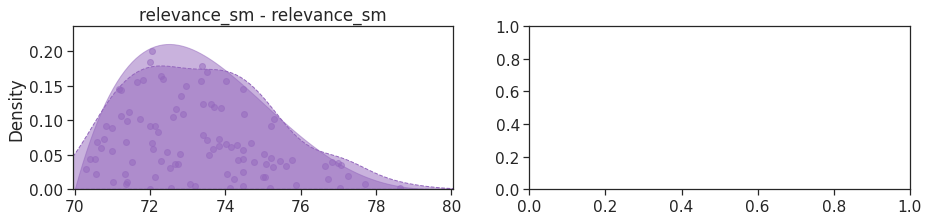

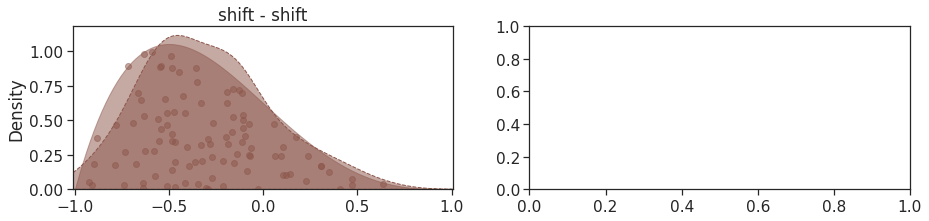

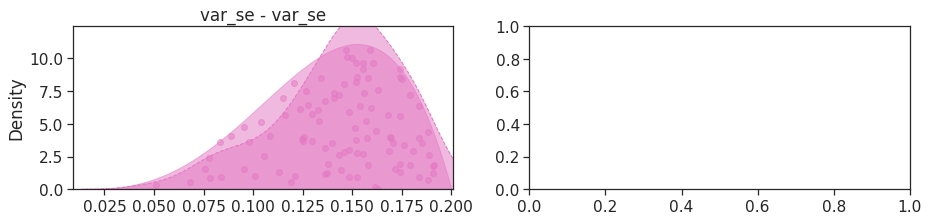

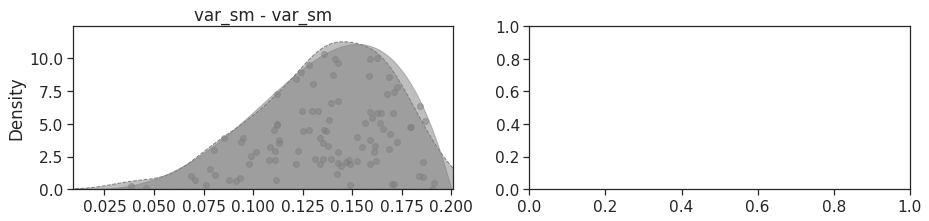

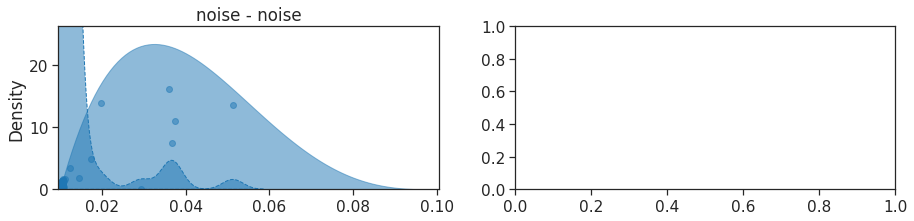

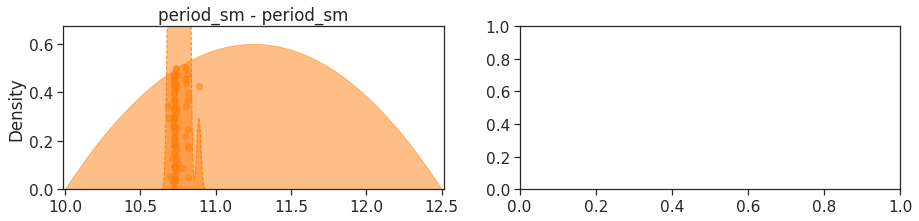

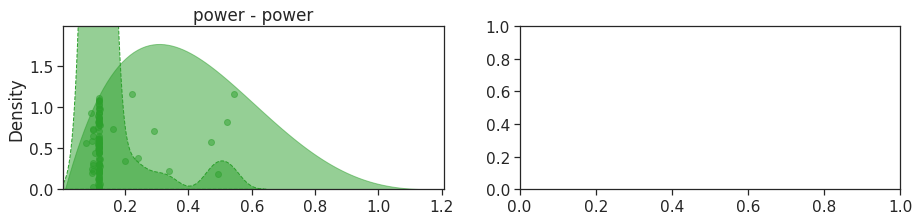

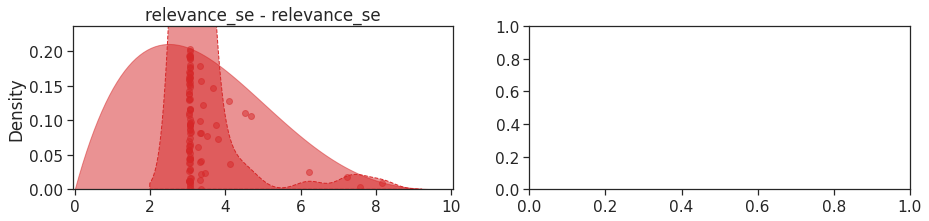

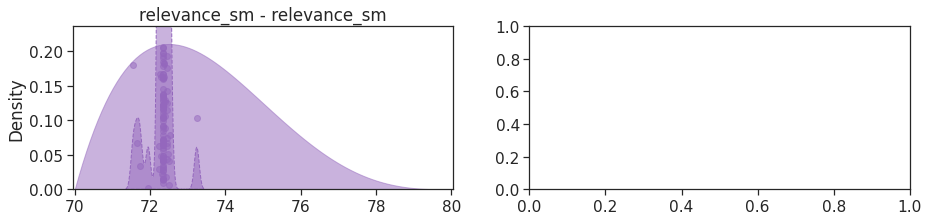

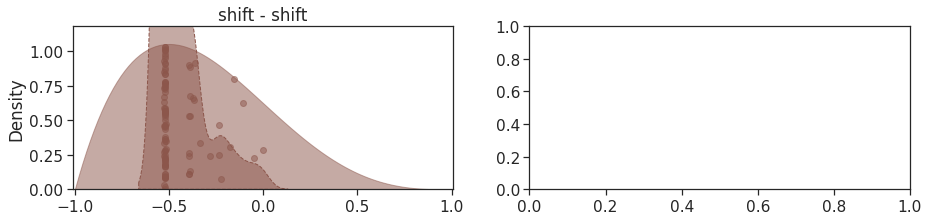

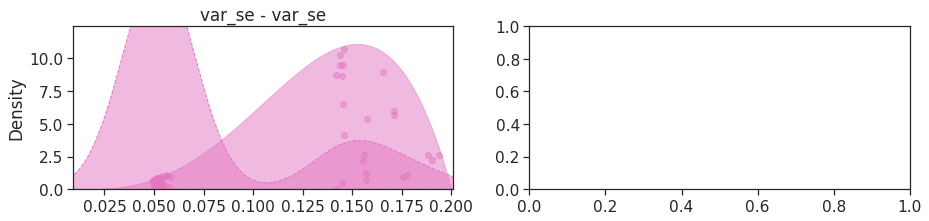

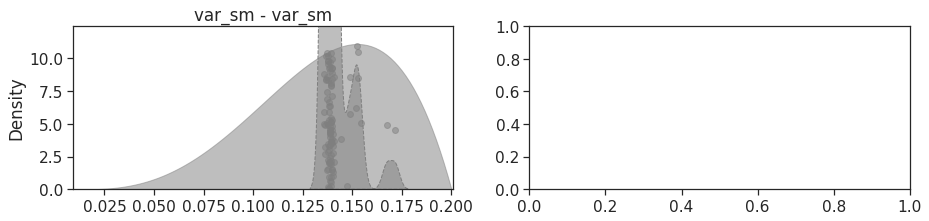

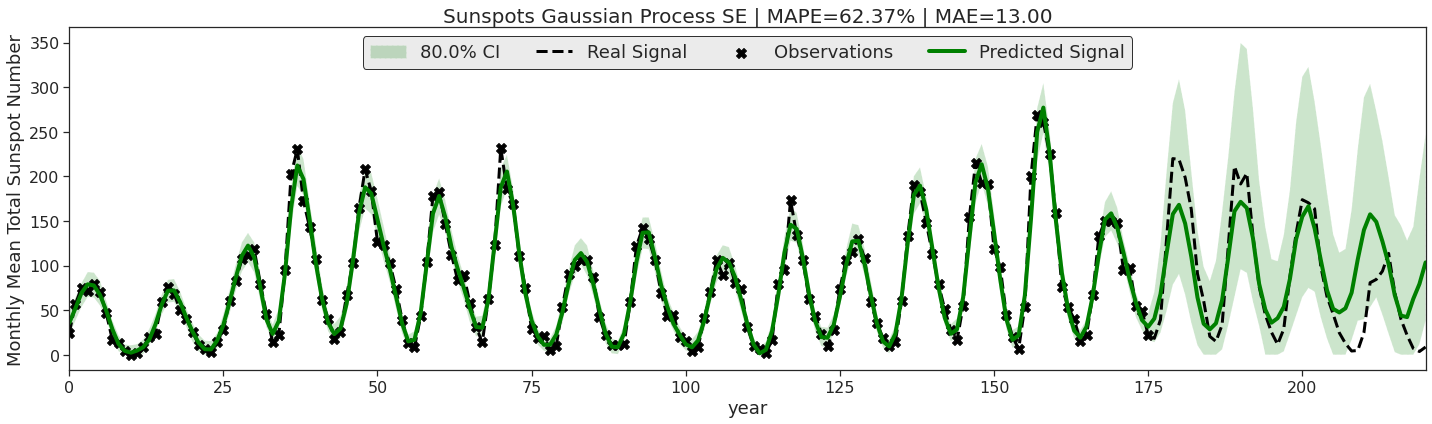

In [4]:
tgp_sm_se.sample_priors()
tgp_sm_se.plot_priors(kde=True)
learning = tg.TgLearning(tgp_sm_se, lr=0.01, pbatch=0.8) #rand_pert=0.0
learning.execute_sgd(1000)
tgp_sm_se.plot_priors(kde=True)
tgp_sm_se.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                          noise=False, plot_samples=False, statistic="Median")

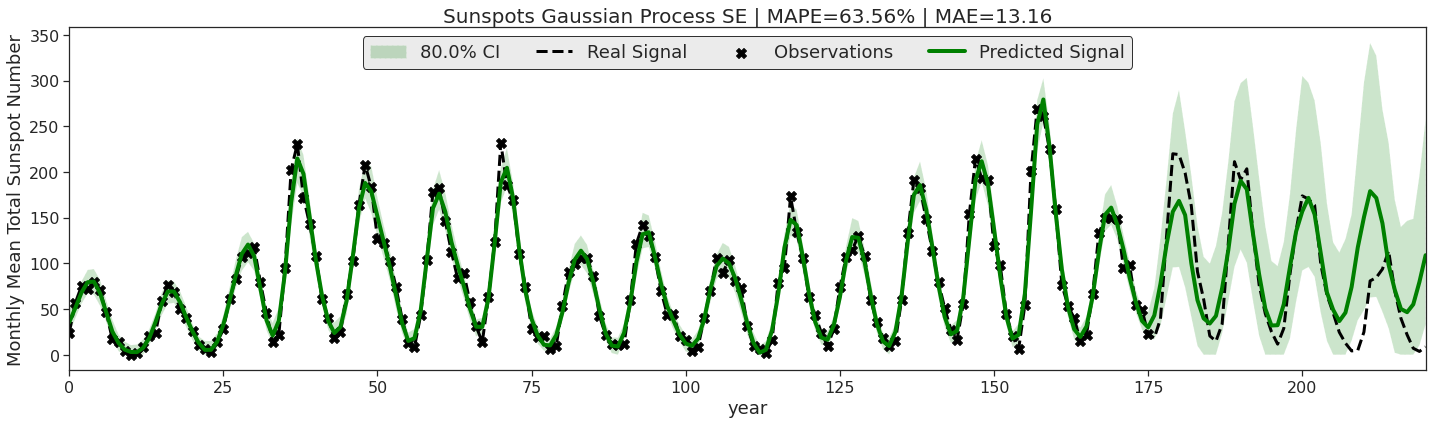

In [5]:
tgp_sm_se.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

## Function Plots $\pi(\theta_0)$ vs $\pi (\theta^*|\hat{y})$

# Sbc first iteration

In [6]:
learning = tg.TgLearning(tgp_sm_se, lr=0.01, pbatch=0.8)  # rand_pert=0.0
theta_0,df_posterior = learning.sbc(niters_sbc= 1, niters_sgd=100);

  0%|                                                                                                         …

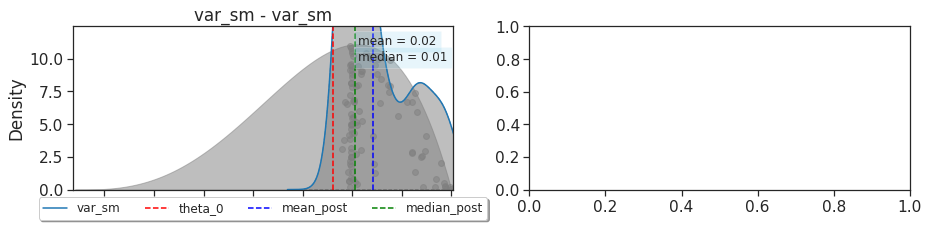

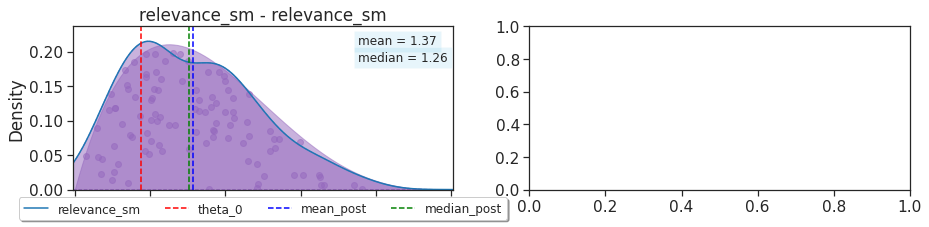

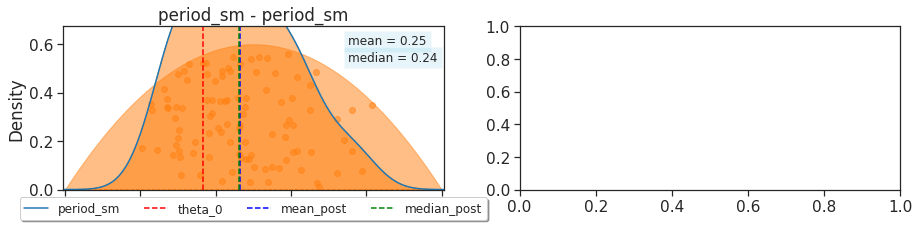

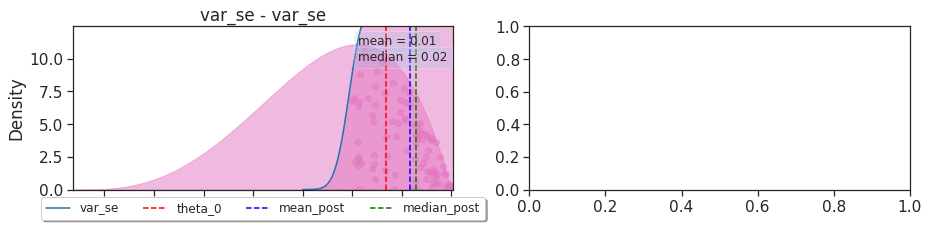

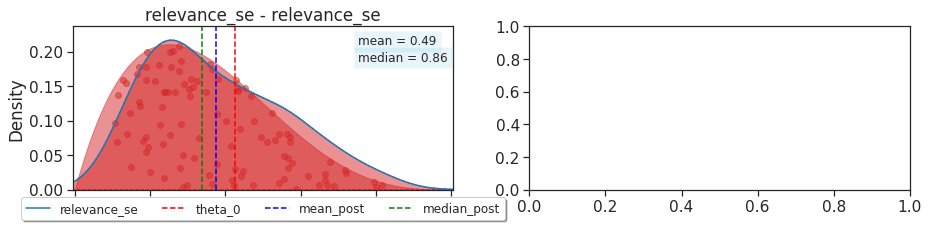

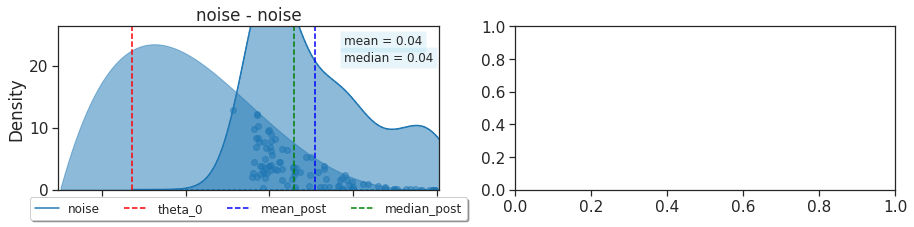

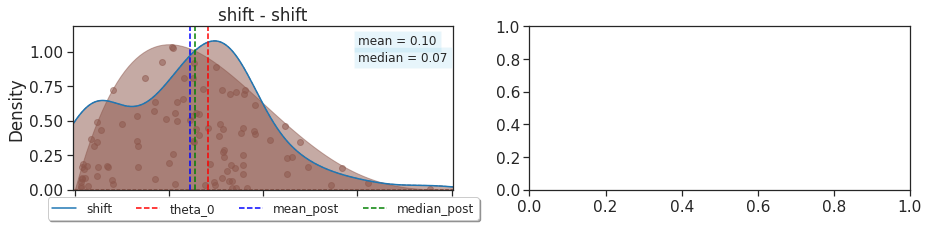

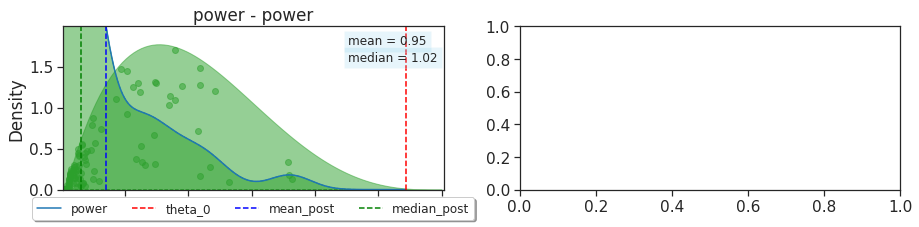

In [7]:
for name, prior in tgp_sm_se.priors.items(): 
        metric_mean = abs(theta_0[name][0] - df_posterior[name].mean())
        metric_median = abs(theta_0[name][0] - df_posterior[name].median())
        
        ax = prior.plot()
        df_posterior[name].plot(kind='density', ax=ax[0][0])  # Plot prior
        
        ax[0][0].text(0.75, 0.95, f'mean = {metric_mean:.2f}', transform=ax[0][0].transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(facecolor='skyblue', alpha=0.2))
        ax[0][0].text(0.75, 0.85, f'median = {metric_median:.2f}', transform=ax[0][0].transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(facecolor='skyblue', alpha=0.2))
        ax[0][0].axvline(x=theta_0[name][0], ymin=0, ymax=1, color="red", linewidth=1.5,
                         linestyle="dashed", label='theta_0')
        ax[0][0].axvline(x=df_posterior[name].mean(), ymin=0, ymax=1, color="blue", 
                         linewidth=1.5, linestyle="dashed", label='mean_post')
        ax[0][0].axvline(x=df_posterior[name].median(), ymin=0, ymax=1, color="green", 
                         linewidth=1.5, linestyle="dashed", label='median_post')
        ax[0][0].legend(loc='upper center', fontsize='12', bbox_to_anchor=(0.5, -0.01), fancybox=True,
                        shadow=True, ncol=4)

# Sbc on 100 iters and 100 iters sgd

### Dataframes $\pi(\theta_0)$, $\pi (\theta^*|\hat{y})$

In [8]:
learning = tg.TgLearning(tgp_sm_se, lr=0.01, pbatch=0.8)  # rand_pert=0.0
df_prior, df_theta = learning.sbc(niters_sbc= 100, niters_sgd=100);

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

### Plots $\pi(\theta_0)$ vs Prior Model 

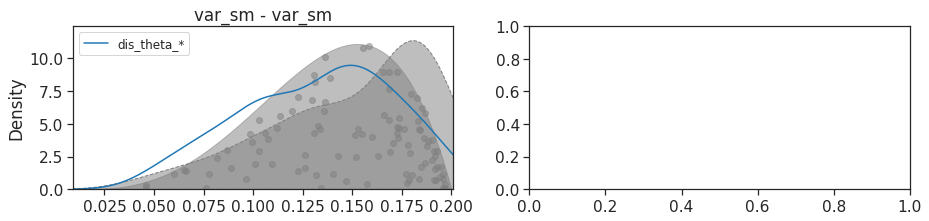

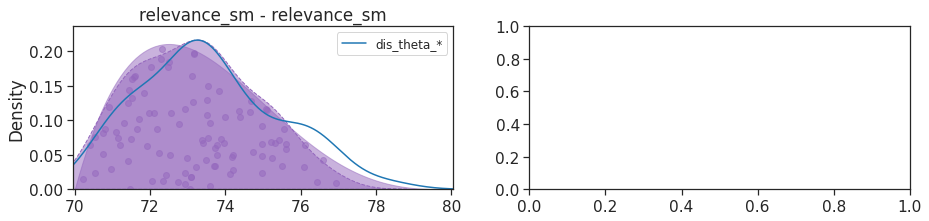

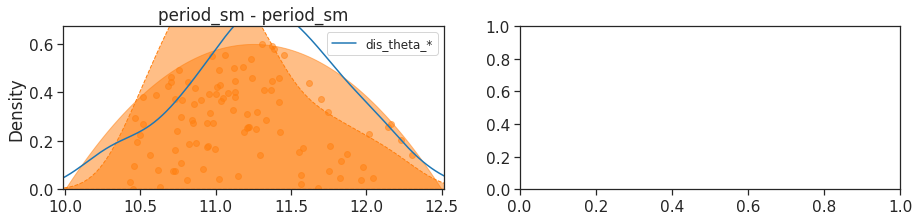

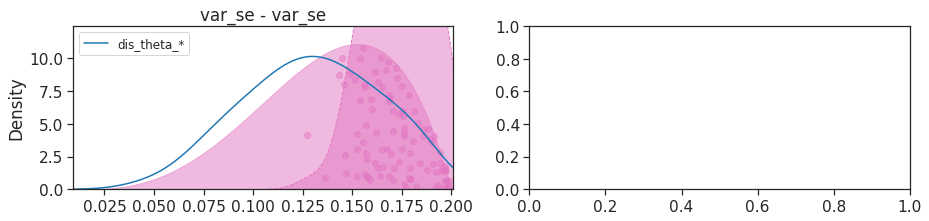

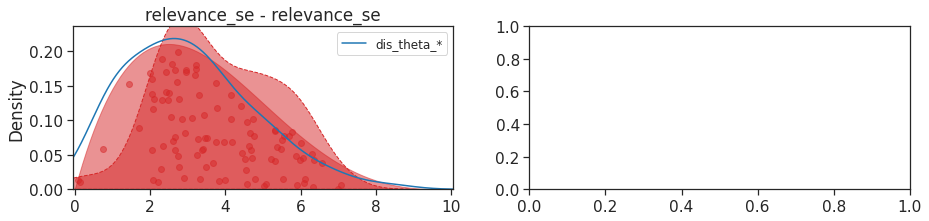

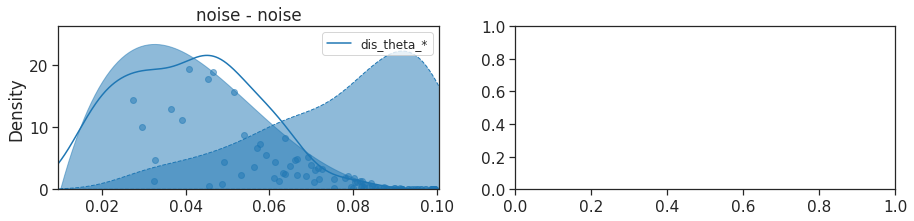

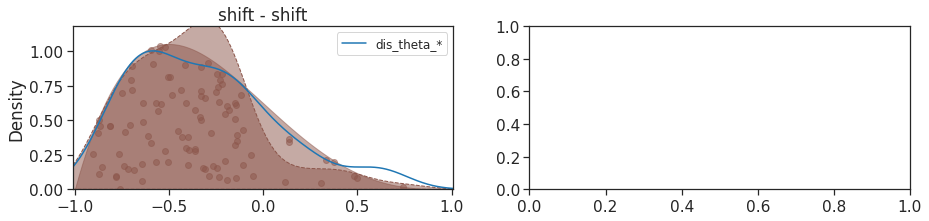

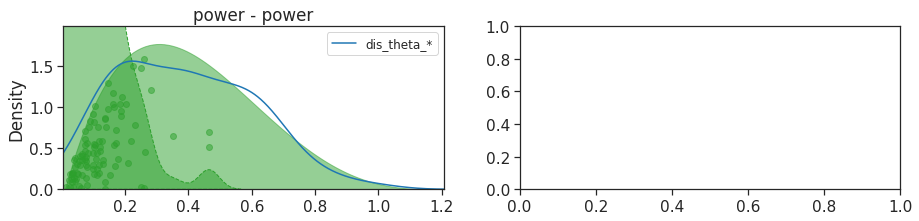

In [9]:
for name,prior in tgp_sm_se.priors.items():
    ax_theta = prior.plot()
    df_prior[name].plot(kind='density', ax=ax_theta[0][0], label='dis_theta_0') #theta_*
    ax_theta[0][0].legend(fontsize=12)
            

### Plots $\pi(\theta^*)$ vs Prior Model 

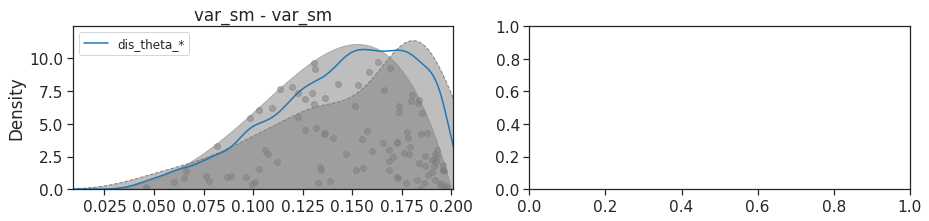

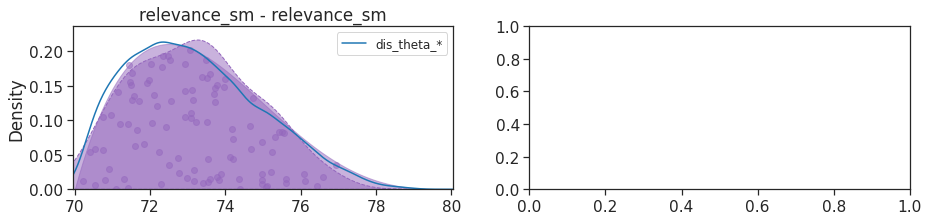

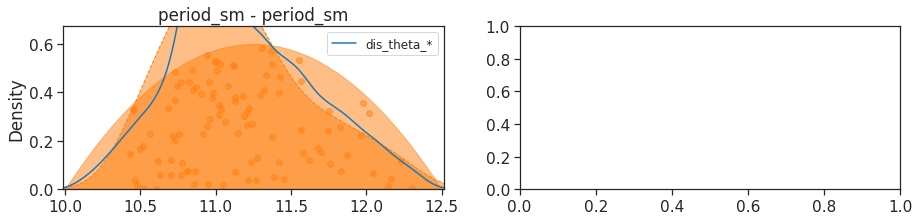

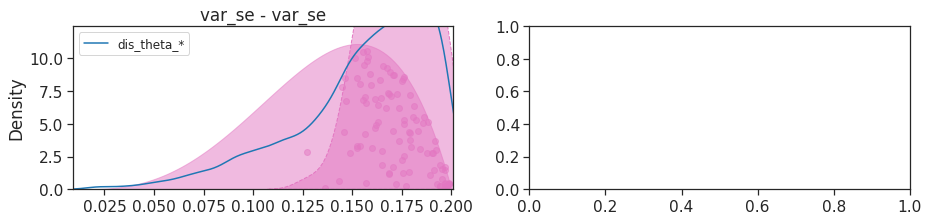

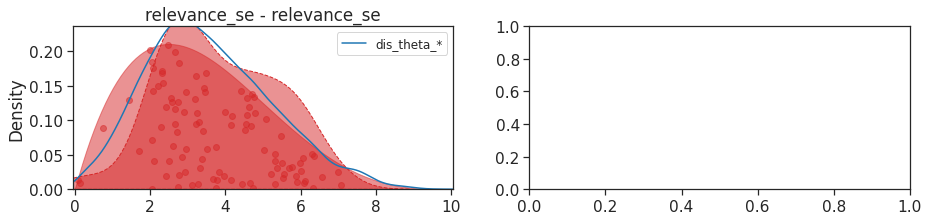

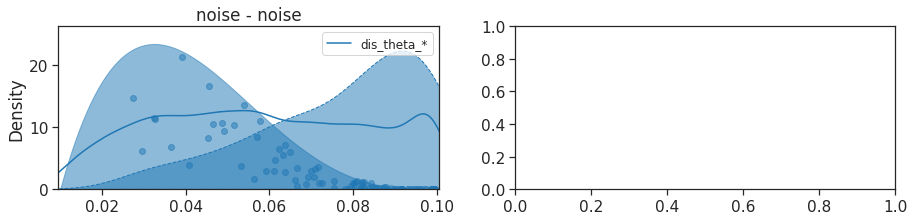

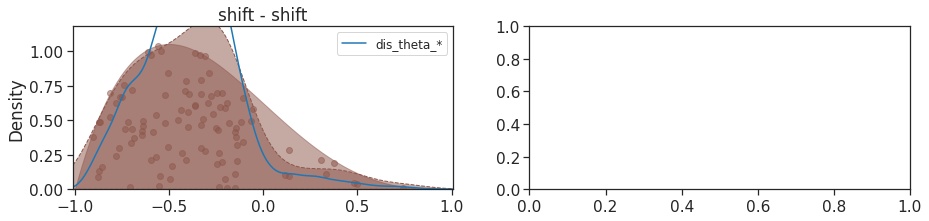

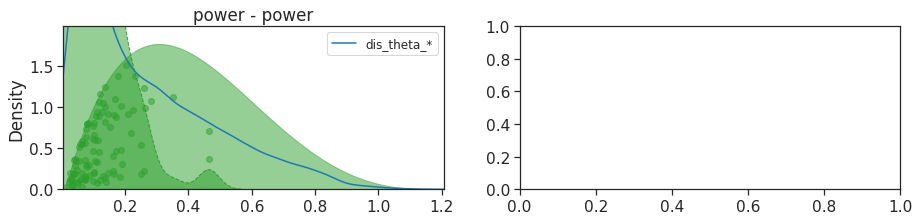

In [10]:
for name,prior in tgp_sm_se.priors.items():
    ax_theta = prior.plot()
    df_theta[name].plot(kind='density', ax=ax_theta[0][0], label='dis_theta_*') #theta_*
    ax_theta[0][0].legend(fontsize=12)
            
        

### Plots $\pi(\theta^*)$ vs $\pi(\theta_0)$

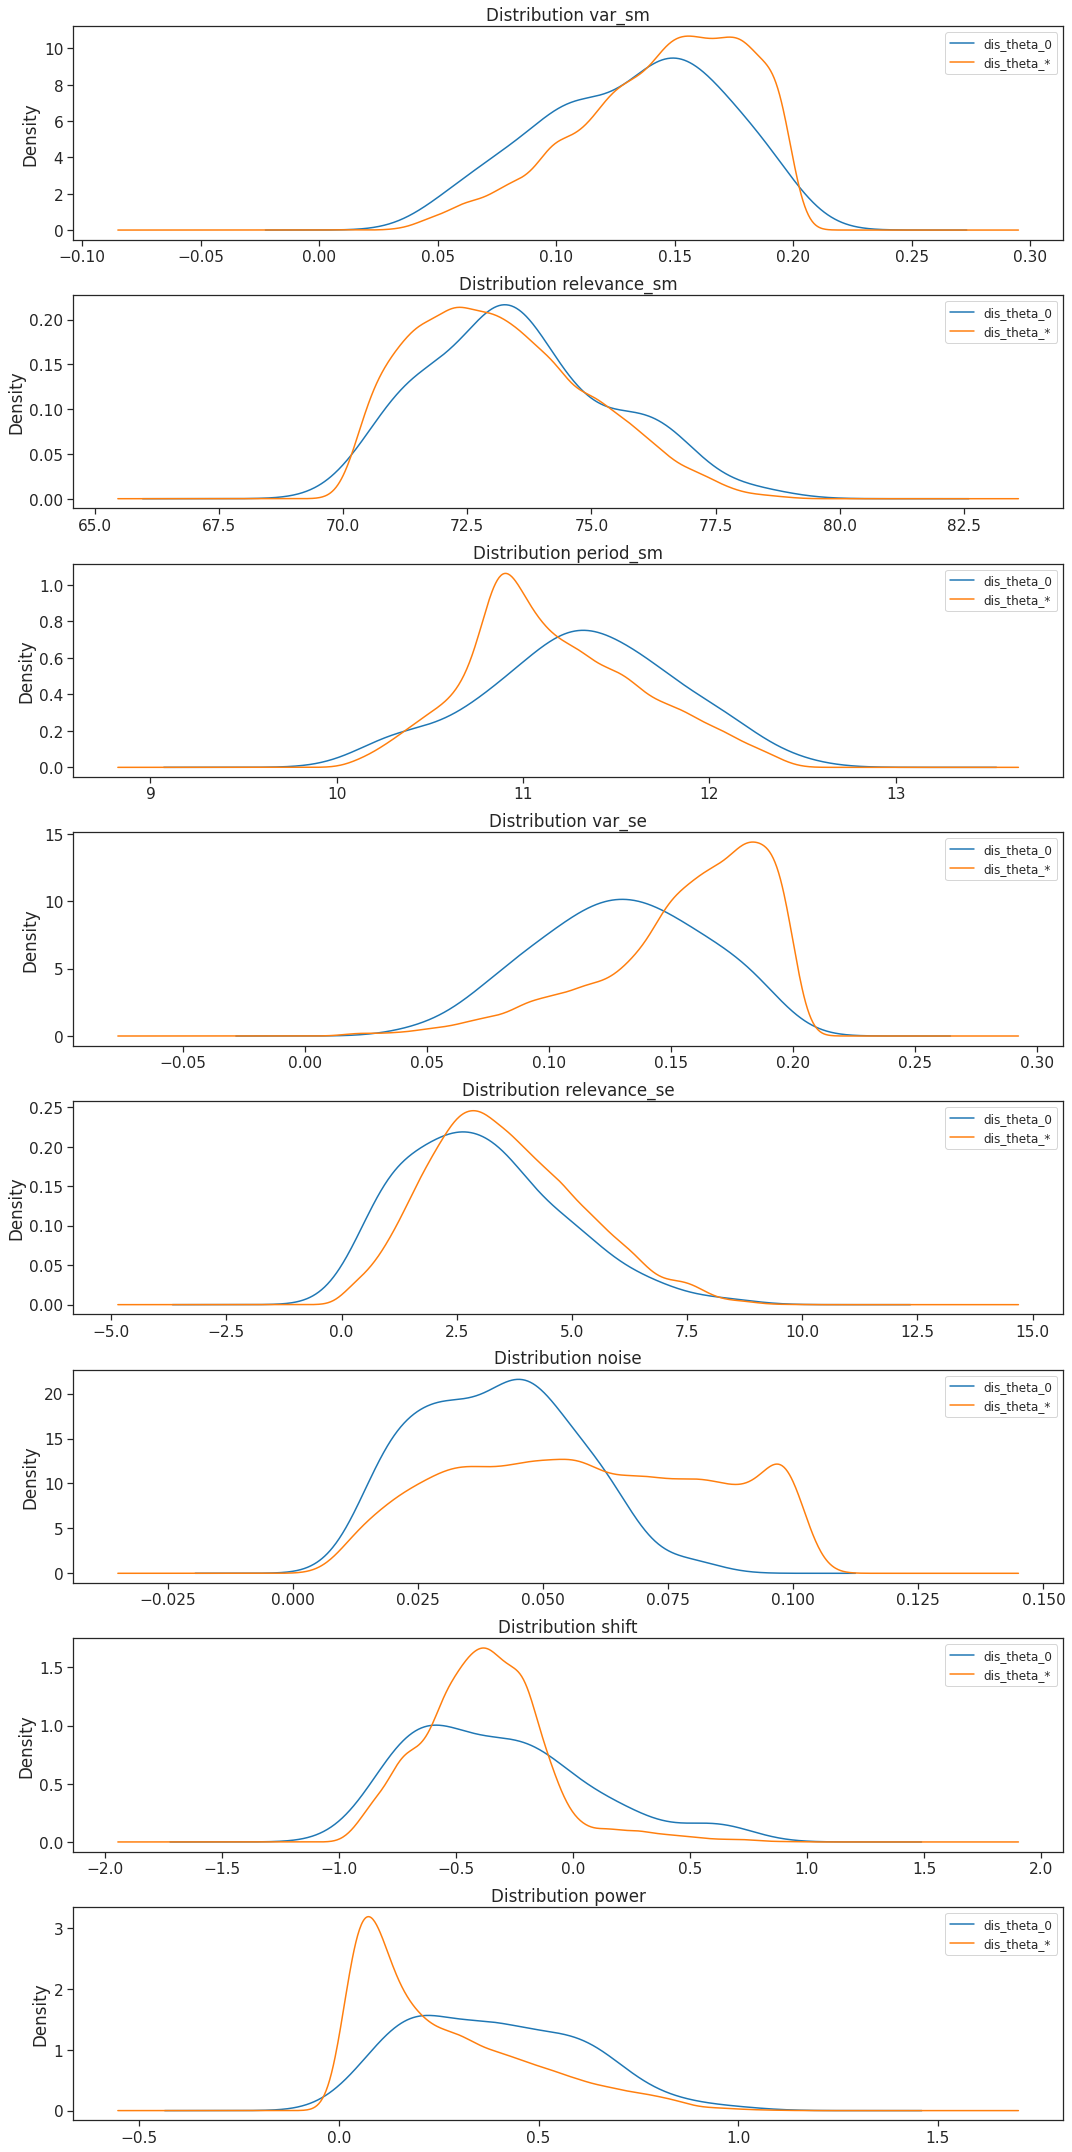

In [11]:
fig, ax = plt.subplots(len(tgp_sm_se.priors.items()),1 ,figsize=(15, 30), squeeze=False)

keys = (tgp_sm_se.priors).keys()
for key in enumerate(keys):
    df_prior[key[1]].plot(kind='density',ax=ax[key[0]][0],label='dis_theta_0')
    df_theta[key[1]].plot(kind='density',ax=ax[key[0]][0],label='dis_theta_*') #theta_*
    ax[key[0]][0].set_title('Distribution '+ key[1])
    fig.tight_layout()
            

    ax[key[0]][0].legend(fontsize=12)

## Wasserstein distance

In [12]:
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

In [13]:
def wasserstein_distance(df_1, df_2, n=200, solve ='sinkhorn'):
    """
    # returns plots if westein
    :df_1: a dataframe, distribution 1
    :df_2: a dataframe, distribution 2
    :n : an int, number of bins of loos metric
    
    """
    x = np.arange(n, dtype=np.float64)
    M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
    M /= M.max()
    for name in df_1.columns.values: 
        count_df_1, division = np.histogram(df_1[name], bins = n, density=True) #funciona aveces 
        count_df_2, division = np.histogram(df_2[name], bins = n, density=True)
        if solve == 'sinkhorn':
            lambd = 1e-3
            G0 = ot.sinkhorn(count_df_1,count_df_2, M, lambd, verbose=True)
            
        if solve == 'emd': # no logro hacer que funcionen
            nada
            
    
        plt.figure(3, figsize=(5, 5))
        ot.plot.plot1D_mat(count_df_1, count_df_2, G0, 'OT matrix'+str(solve))
        plt.show()


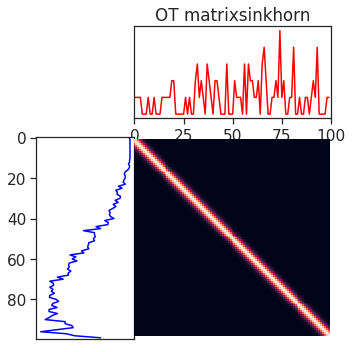

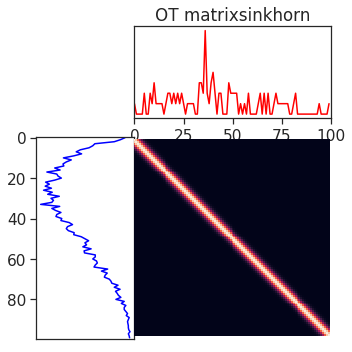

It.  |Err         
-------------------
    0|3.048595e+00|
   10|1.891719e+00|
   20|1.433746e+00|
   30|1.155253e+00|
   40|9.747467e-01|
   50|8.530978e-01|
   60|7.688949e-01|
   70|7.093431e-01|
   80|6.663472e-01|
   90|6.346638e-01|
  100|6.108691e-01|
  110|5.927088e-01|
  120|5.786757e-01|
  130|5.677374e-01|
  140|5.591662e-01|
  150|5.524327e-01|
  160|5.471416e-01|
  170|5.429903e-01|
  180|5.397435e-01|
  190|5.372156e-01|
It.  |Err         
-------------------
  200|5.352592e-01|
  210|5.337565e-01|
  220|5.326132e-01|
  230|5.317539e-01|
  240|5.311178e-01|
  250|5.306566e-01|
  260|5.303315e-01|
  270|5.301116e-01|
  280|5.299725e-01|
  290|5.298947e-01|
  300|5.298629e-01|
  310|5.298651e-01|
  320|5.298918e-01|
  330|5.299358e-01|
  340|5.299914e-01|
  350|5.300543e-01|
  360|5.301212e-01|
  370|5.301896e-01|
  380|5.302578e-01|
  390|5.303244e-01|
It.  |Err         
-------------------
  400|5.303886e-01|
  410|5.304498e-01|
  420|5.305075e-01|
  430|5.305615e-01|
  4

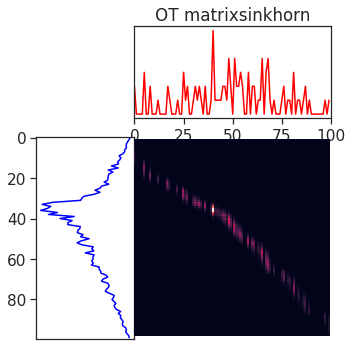

It.  |Err         
-------------------
    0|6.864022e+01|
   10|6.095683e+01|
   20|5.478779e+01|
   30|4.957475e+01|
   40|4.516629e+01|
   50|4.141361e+01|
   60|3.819519e+01|
   70|3.542201e+01|
   80|3.302957e+01|
   90|3.096767e+01|
  100|2.919214e+01|
  110|2.766466e+01|
  120|2.635198e+01|
  130|2.522556e+01|
  140|2.426332e+01|
  150|2.344778e+01|
  160|2.276195e+01|
  170|2.218918e+01|
  180|2.171394e+01|
  190|2.132204e+01|
It.  |Err         
-------------------
  200|2.100069e+01|
  210|2.073866e+01|
  220|2.052619e+01|
  230|2.035494e+01|
  240|2.021781e+01|
  250|2.010884e+01|
  260|2.002301e+01|
  270|1.995607e+01|
  280|1.990445e+01|
  290|1.986513e+01|
  300|1.983565e+01|
  310|1.981400e+01|
  320|1.979853e+01|
  330|1.978792e+01|
  340|1.978111e+01|
  350|1.977725e+01|
  360|1.977564e+01|
  370|1.977573e+01|
  380|1.977709e+01|
  390|1.977936e+01|
It.  |Err         
-------------------
  400|1.978227e+01|
  410|1.978561e+01|
  420|1.978920e+01|
  430|1.979292e+01|
  4

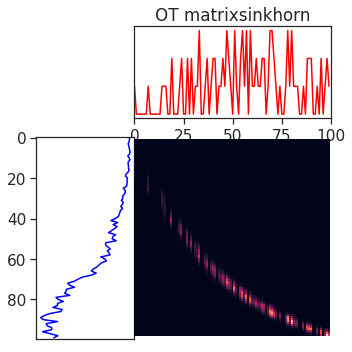

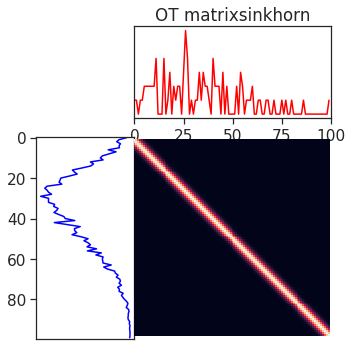

It.  |Err         
-------------------
    0|1.677107e+02|
   10|1.396735e+02|
   20|1.214801e+02|
   30|1.069702e+02|
   40|9.485676e+01|
   50|8.642454e+01|
   60|8.159364e+01|
   70|7.798715e+01|
   80|7.511701e+01|
   90|7.276896e+01|
  100|7.081527e+01|
  110|6.917018e+01|
  120|6.777163e+01|
  130|6.657251e+01|
  140|6.553668e+01|
  150|6.463644e+01|
  160|6.385050e+01|
  170|6.316219e+01|
  180|6.255813e+01|
  190|6.202728e+01|
It.  |Err         
-------------------
  200|6.156036e+01|
  210|6.114939e+01|
  220|6.078750e+01|
  230|6.046870e+01|
  240|6.018777e+01|
  250|5.994016e+01|
  260|5.972187e+01|
  270|5.952939e+01|
  280|5.935966e+01|
  290|5.920995e+01|
  300|5.907792e+01|
  310|5.896144e+01|
  320|5.885869e+01|
  330|5.876803e+01|
  340|5.868803e+01|
  350|5.861742e+01|
  360|5.855508e+01|
  370|5.850003e+01|
  380|5.845139e+01|
  390|5.840841e+01|
It.  |Err         
-------------------
  400|5.837040e+01|
  410|5.833678e+01|
  420|5.830702e+01|
  430|5.828066e+01|
  4

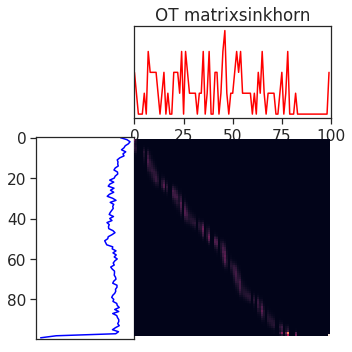

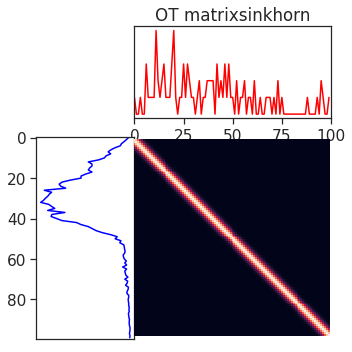

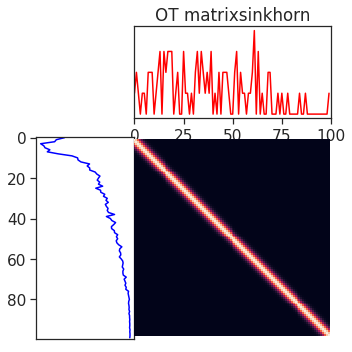

In [14]:
wasserstein_distance(df_theta,df_prior, n=100)

# Modelo 2 a analizar con kernel SIN*SE + POL

In [15]:
CO2_monthly = pd.read_csv("co2_mm_mlo.csv")
CO2_monthly
CO2_monthly = CO2_monthly[CO2_monthly['average'] > 0]
CO2_monthly = CO2_monthly[len(CO2_monthly.index)-200:]
CO2_monthly = CO2_monthly.reset_index()
CO2_monthly['index'] = CO2_monthly.index
CO2_monthly = CO2_monthly[['index','average']]
t = CO2_monthly['index']
y = CO2_monthly['average']
particion = 0.8
obs_final = int(particion*len(t))
train_index = range(obs_final)
valid_index = range(obs_final,len(t) )
t_obs = t[train_index]
y_obs = y[train_index]
t_val = t[valid_index]
y_val = y[valid_index]

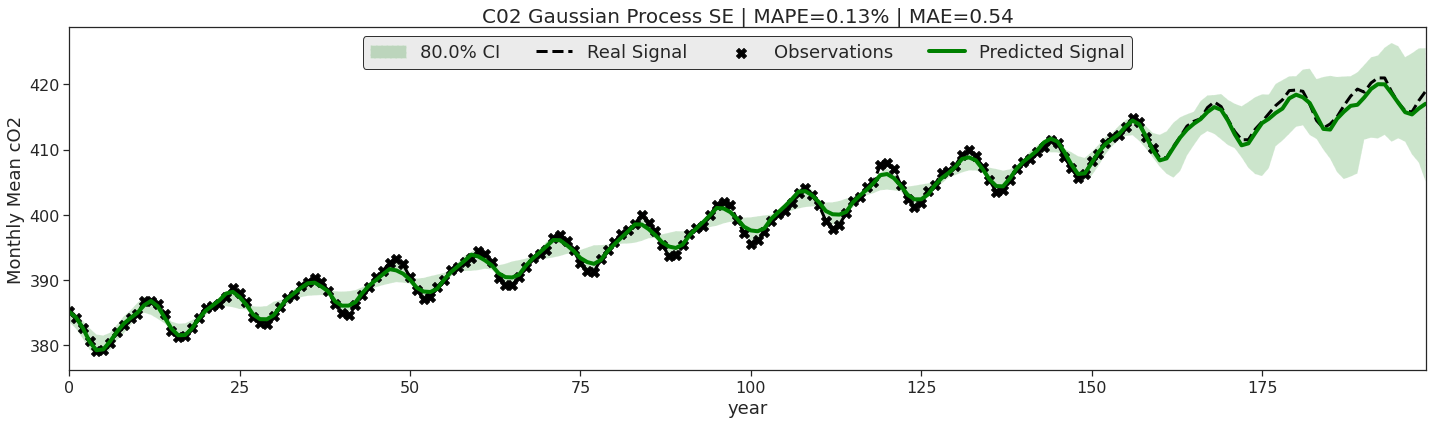

In [16]:
#SIN*SE + POL 
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_sin = tg.TgPriorUnivariate('var_sin', ['var_sin'], dim=dim, low=0, high=4, alpha=2, beta=4)
    var_se = tg.TgPriorUnivariate('var_se', ['var_se'], dim=dim, low=0, high=4, alpha=2, beta=4)
    
    relevance_sin = tg.TgPriorUnivariate('relevance_sin', ['relevance_sin'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_pol = tg.TgPriorUnivariate('relevance_pol', ['relevance_pol'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_se = tg.TgPriorUnivariate('relevance_se', ['relevance_se'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2

    freedom = tg.TgPriorUnivariate('freedom', ['freedom'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPriorUnivariate('period', ['periond'], dim=dim, low=0.04, high=0.08, alpha=4, beta=2)
    power = tg.TgPriorUnivariate('power', ['power'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    #noise = tg.TgPriorUnivariate('noise', ['noise'], dim=dim, low=0.01, high=0.1, alpha=2, beta=4)

    SIN = tg.SIN(var_sin, relevance_sin, period)
    SE = tg.SE(var_se, relevance_se)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SIN, SE)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp
tgp = model(CO2_monthly, train_index)

tgp.plot_predict('C02 Gaussian Process SE', 'year', "Monthly Mean cO2", nsamples = 100, 
                    noise=False, plot_samples=False, statistic="Median")

  0%|                                                                                                         …

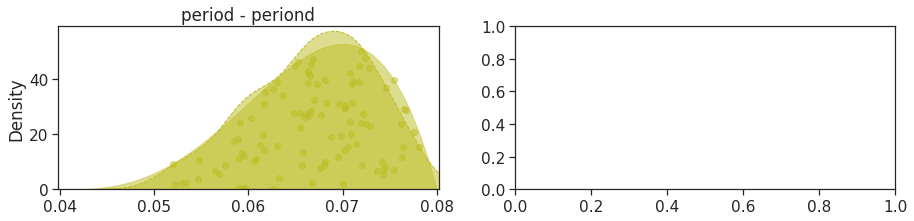

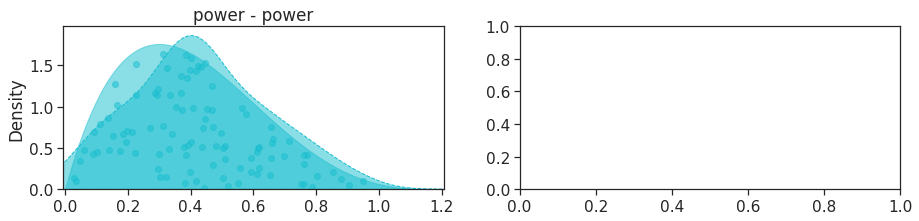

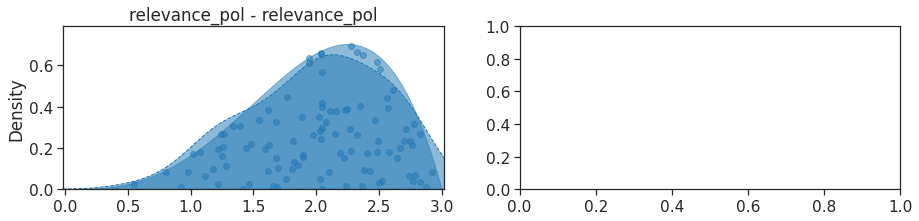

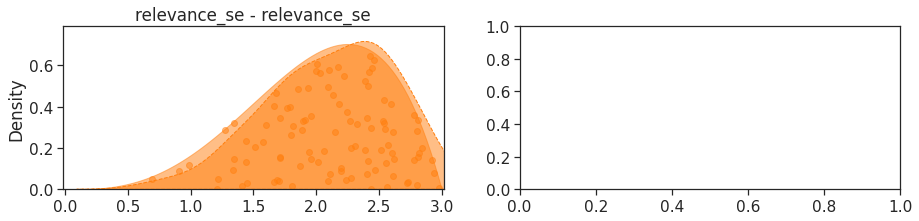

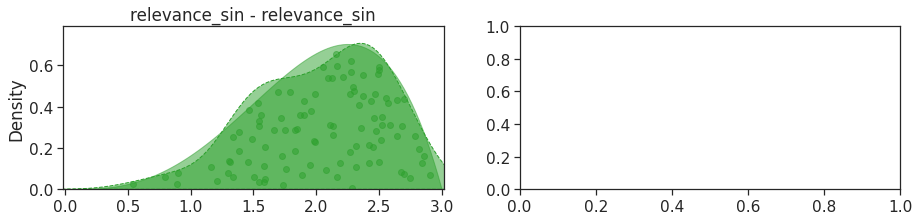

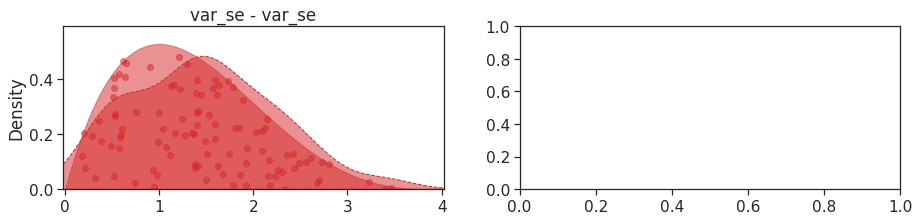

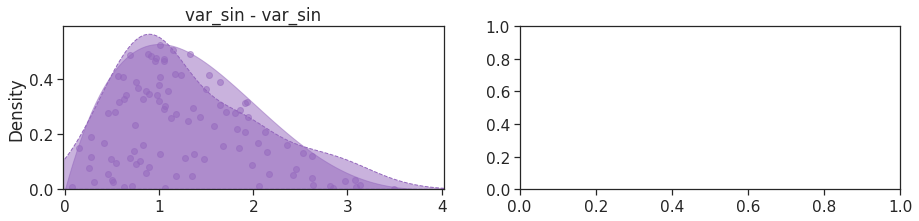

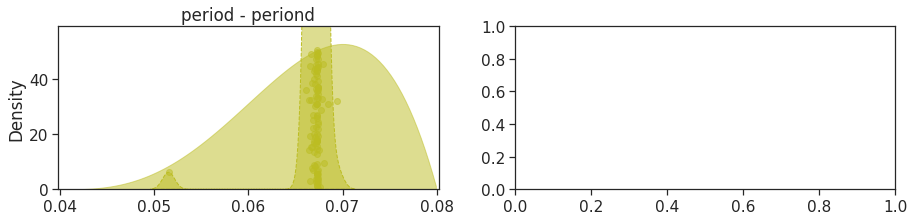

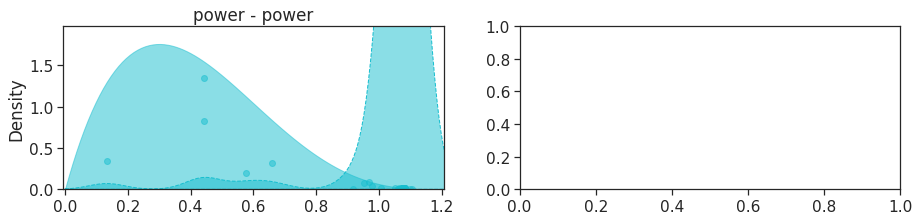

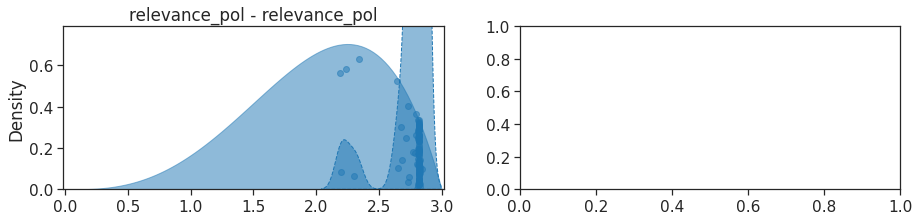

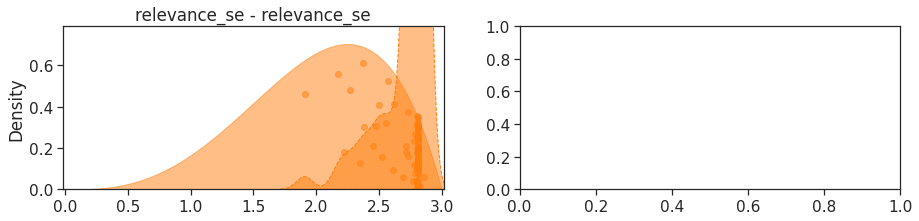

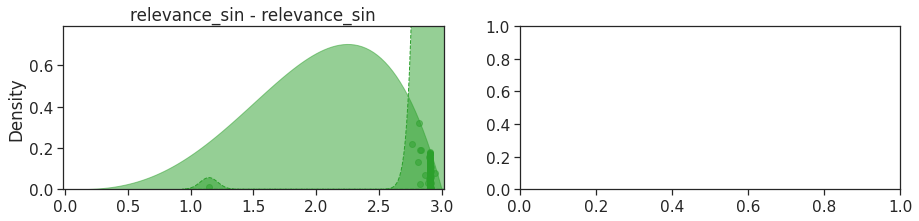

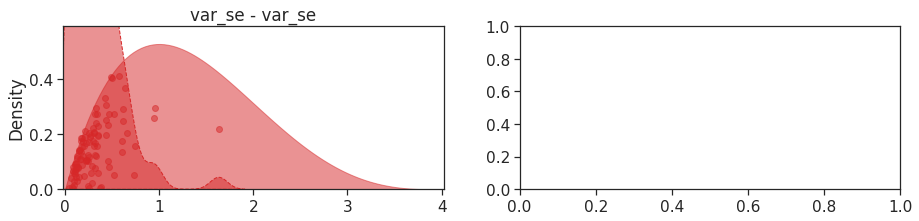

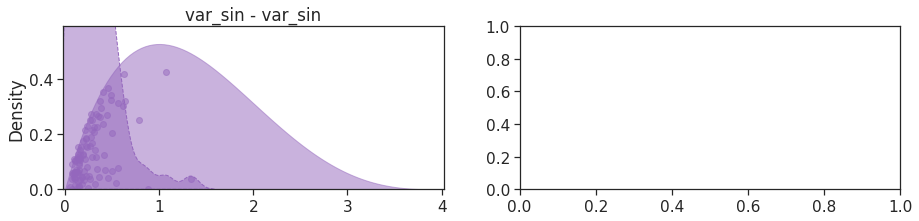

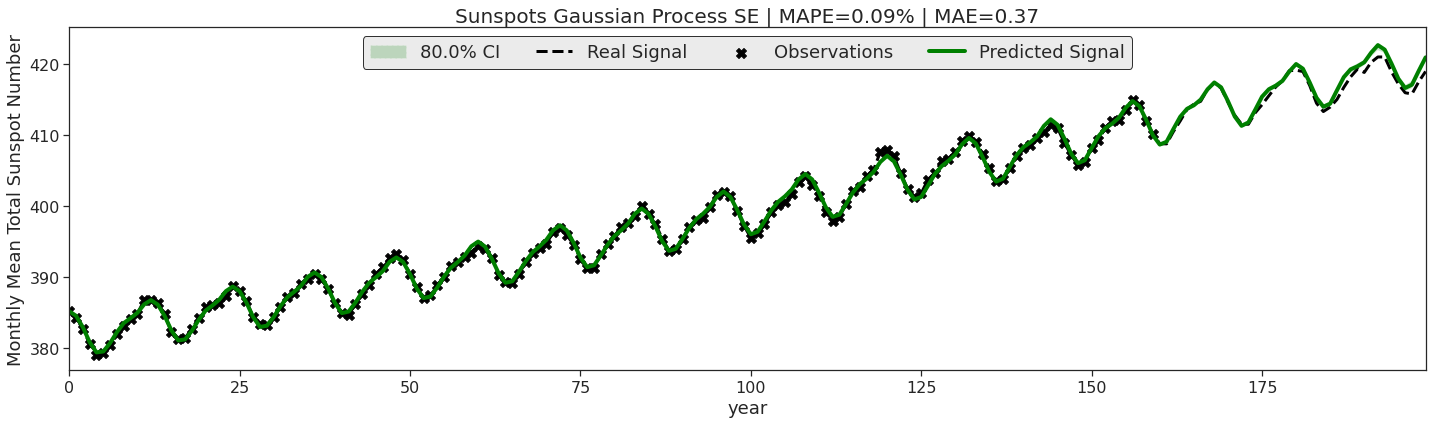

In [17]:
tgp.sample_priors()
tgp.plot_priors(kde=True)
learning = tg.TgLearning(tgp, lr=0.01, pbatch=0.8) #rand_pert=0.0
learning.execute_sgd(1000)
tgp.plot_priors(kde=True)
tgp.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 100, 
                          noise=False, plot_samples=False, statistic="Median")


## Function Plots $\pi(\theta_0)$ vs $\pi (\theta^*|\hat{y})$

# Sbc first iteration

In [18]:
learning = tg.TgLearning(tgp, lr=0.01, pbatch=0.8)  # rand_pert=0.0
theta_0,df_posterior = learning.sbc(niters_sbc= 1, niters_sgd=100);

  0%|                                                                                                         …

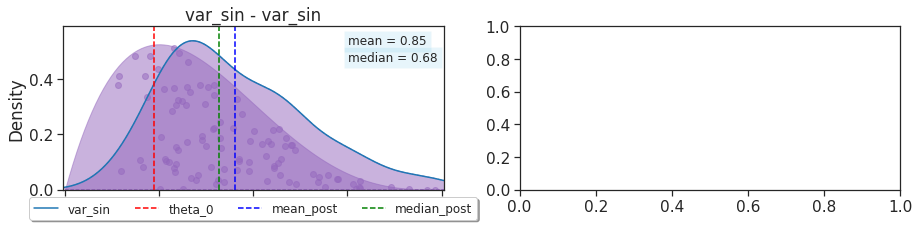

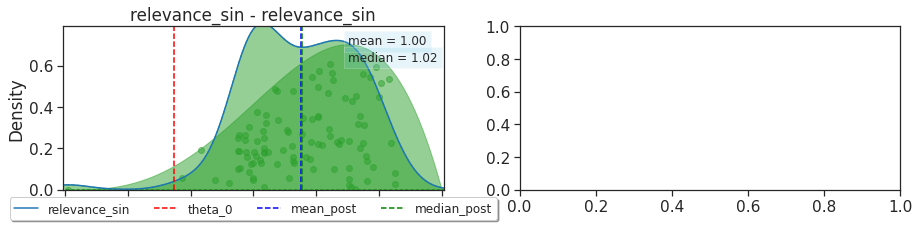

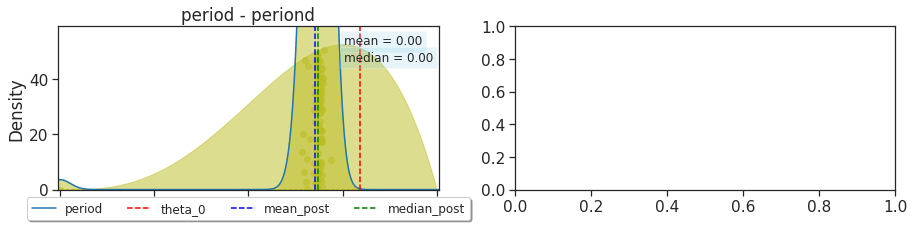

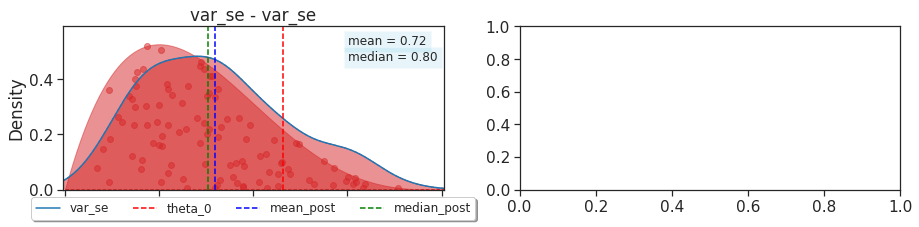

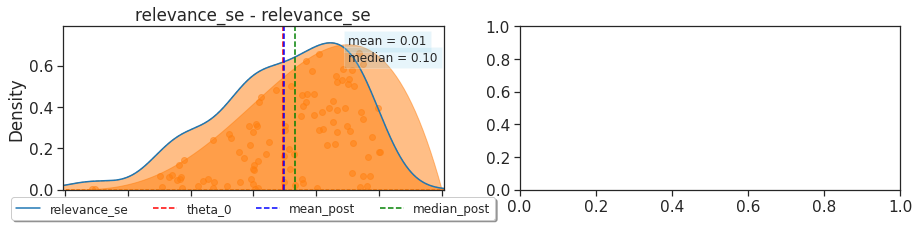

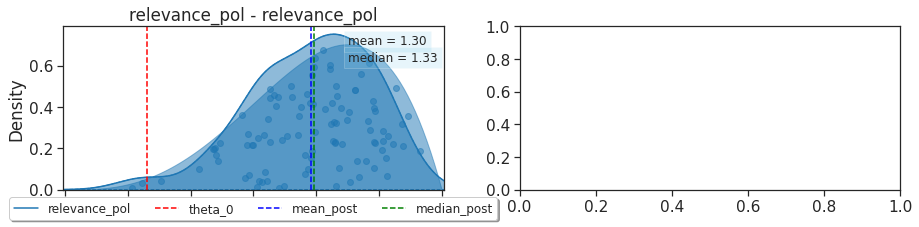

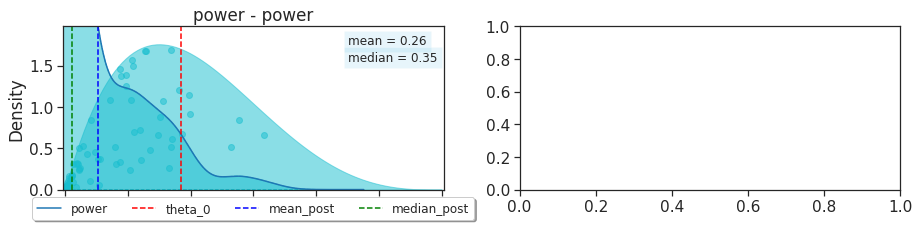

In [19]:
for name, prior in tgp.priors.items(): 
        metric_mean = abs(theta_0[name][0] - df_posterior[name].mean())
        metric_median = abs(theta_0[name][0] - df_posterior[name].median())
        
        ax = prior.plot()
        df_posterior[name].plot(kind='density', ax=ax[0][0])  # Plot prior
        
        ax[0][0].text(0.75, 0.95, f'mean = {metric_mean:.2f}', transform=ax[0][0].transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(facecolor='skyblue', alpha=0.2))
        ax[0][0].text(0.75, 0.85, f'median = {metric_median:.2f}', transform=ax[0][0].transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(facecolor='skyblue', alpha=0.2))
        ax[0][0].axvline(x=theta_0[name][0], ymin=0, ymax=1, color="red", linewidth=1.5,
                         linestyle="dashed", label='theta_0')
        ax[0][0].axvline(x=df_posterior[name].mean(), ymin=0, ymax=1, color="blue", 
                         linewidth=1.5, linestyle="dashed", label='mean_post')
        ax[0][0].axvline(x=df_posterior[name].median(), ymin=0, ymax=1, color="green", 
                         linewidth=1.5, linestyle="dashed", label='median_post')
        ax[0][0].legend(loc='upper center', fontsize='12', bbox_to_anchor=(0.5, -0.01), fancybox=True,
                        shadow=True, ncol=4)

# Sbc on 100 iters and 100 iters sgd

### Dataframes $\pi(\theta_0)$, $\pi (\theta^*|\hat{y})$

In [20]:
learning = tg.TgLearning(tgp, lr=0.01, pbatch=0.8)  # rand_pert=0.0
df_prior, df_theta = learning.sbc(niters_sbc= 100, niters_sgd=100);

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

### Plots $\pi(\theta_0)$ vs Prior Model 

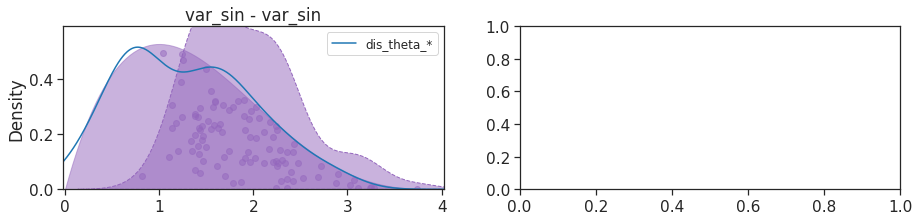

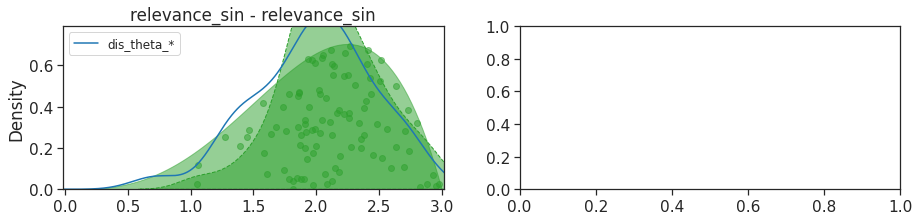

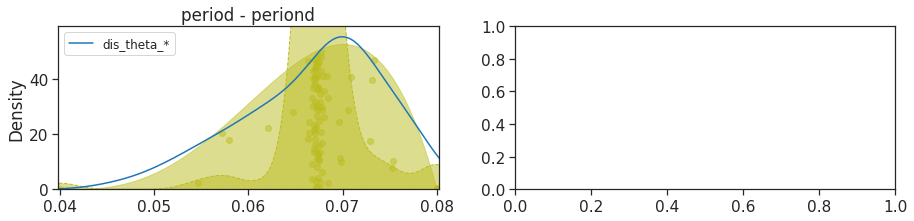

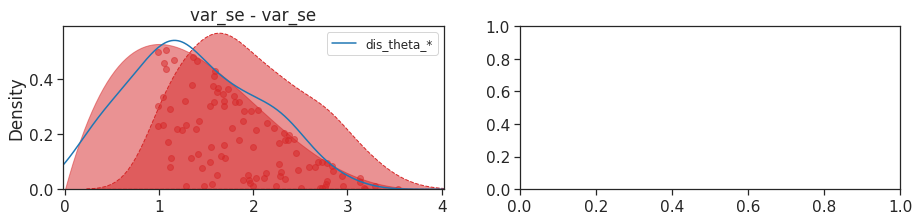

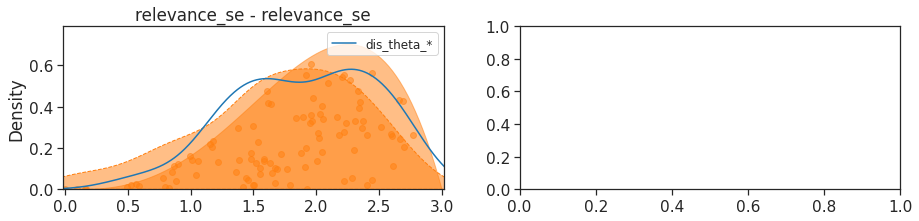

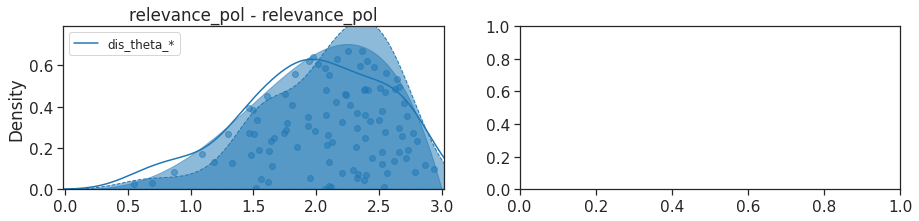

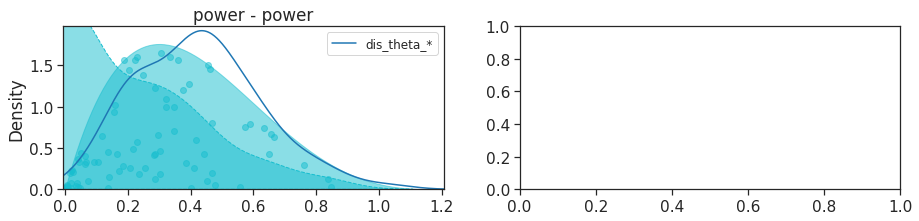

In [21]:
for name,prior in tgp.priors.items():
    ax_theta = prior.plot()
    df_prior[name].plot(kind='density', ax=ax_theta[0][0], label='dis_theta_*') #theta_*
    ax_theta[0][0].legend(fontsize=12)

### Plots $\pi(\theta^*)$ vs Prior Model 

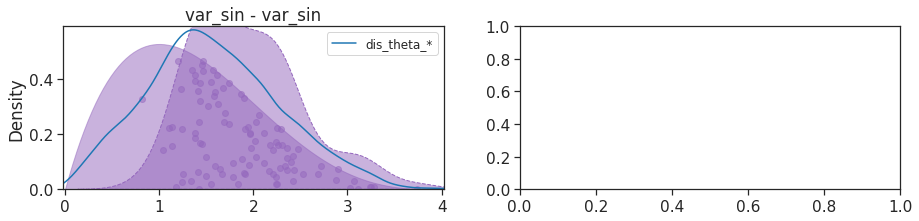

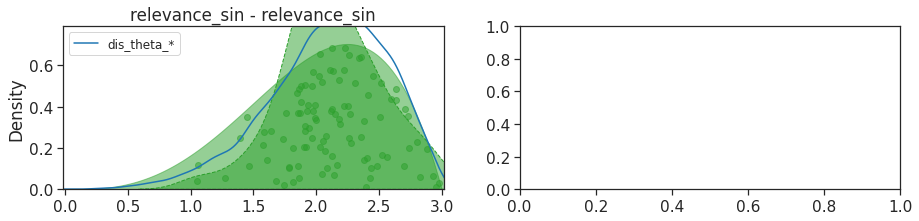

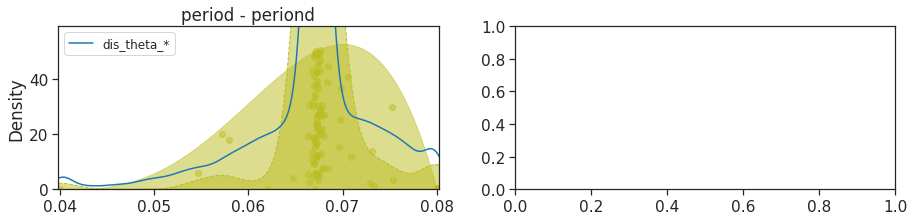

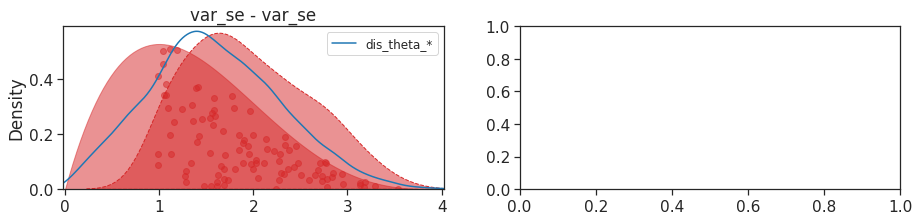

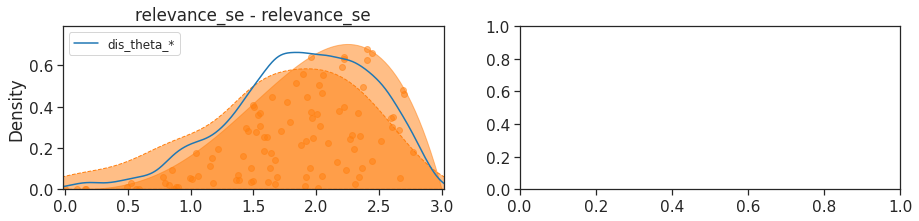

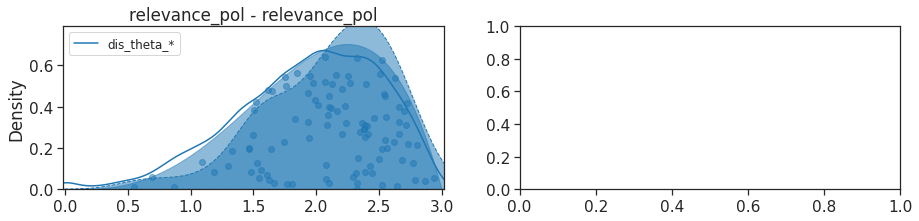

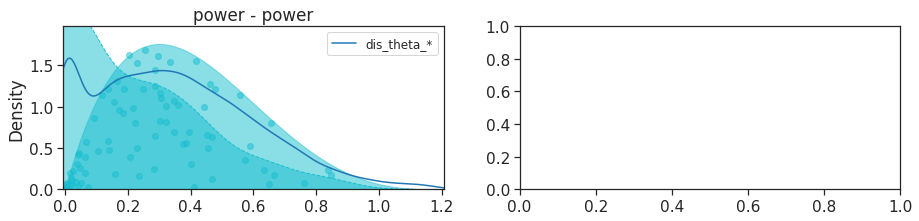

In [22]:
for name,prior in tgp.priors.items():
    ax_theta = prior.plot()
    df_theta[name].plot(kind='density', ax=ax_theta[0][0], label='dis_theta_*') #theta_*
    ax_theta[0][0].legend(fontsize=12)
            

### Plots $\pi(\theta^*)$ vs $\pi(\theta_0)$

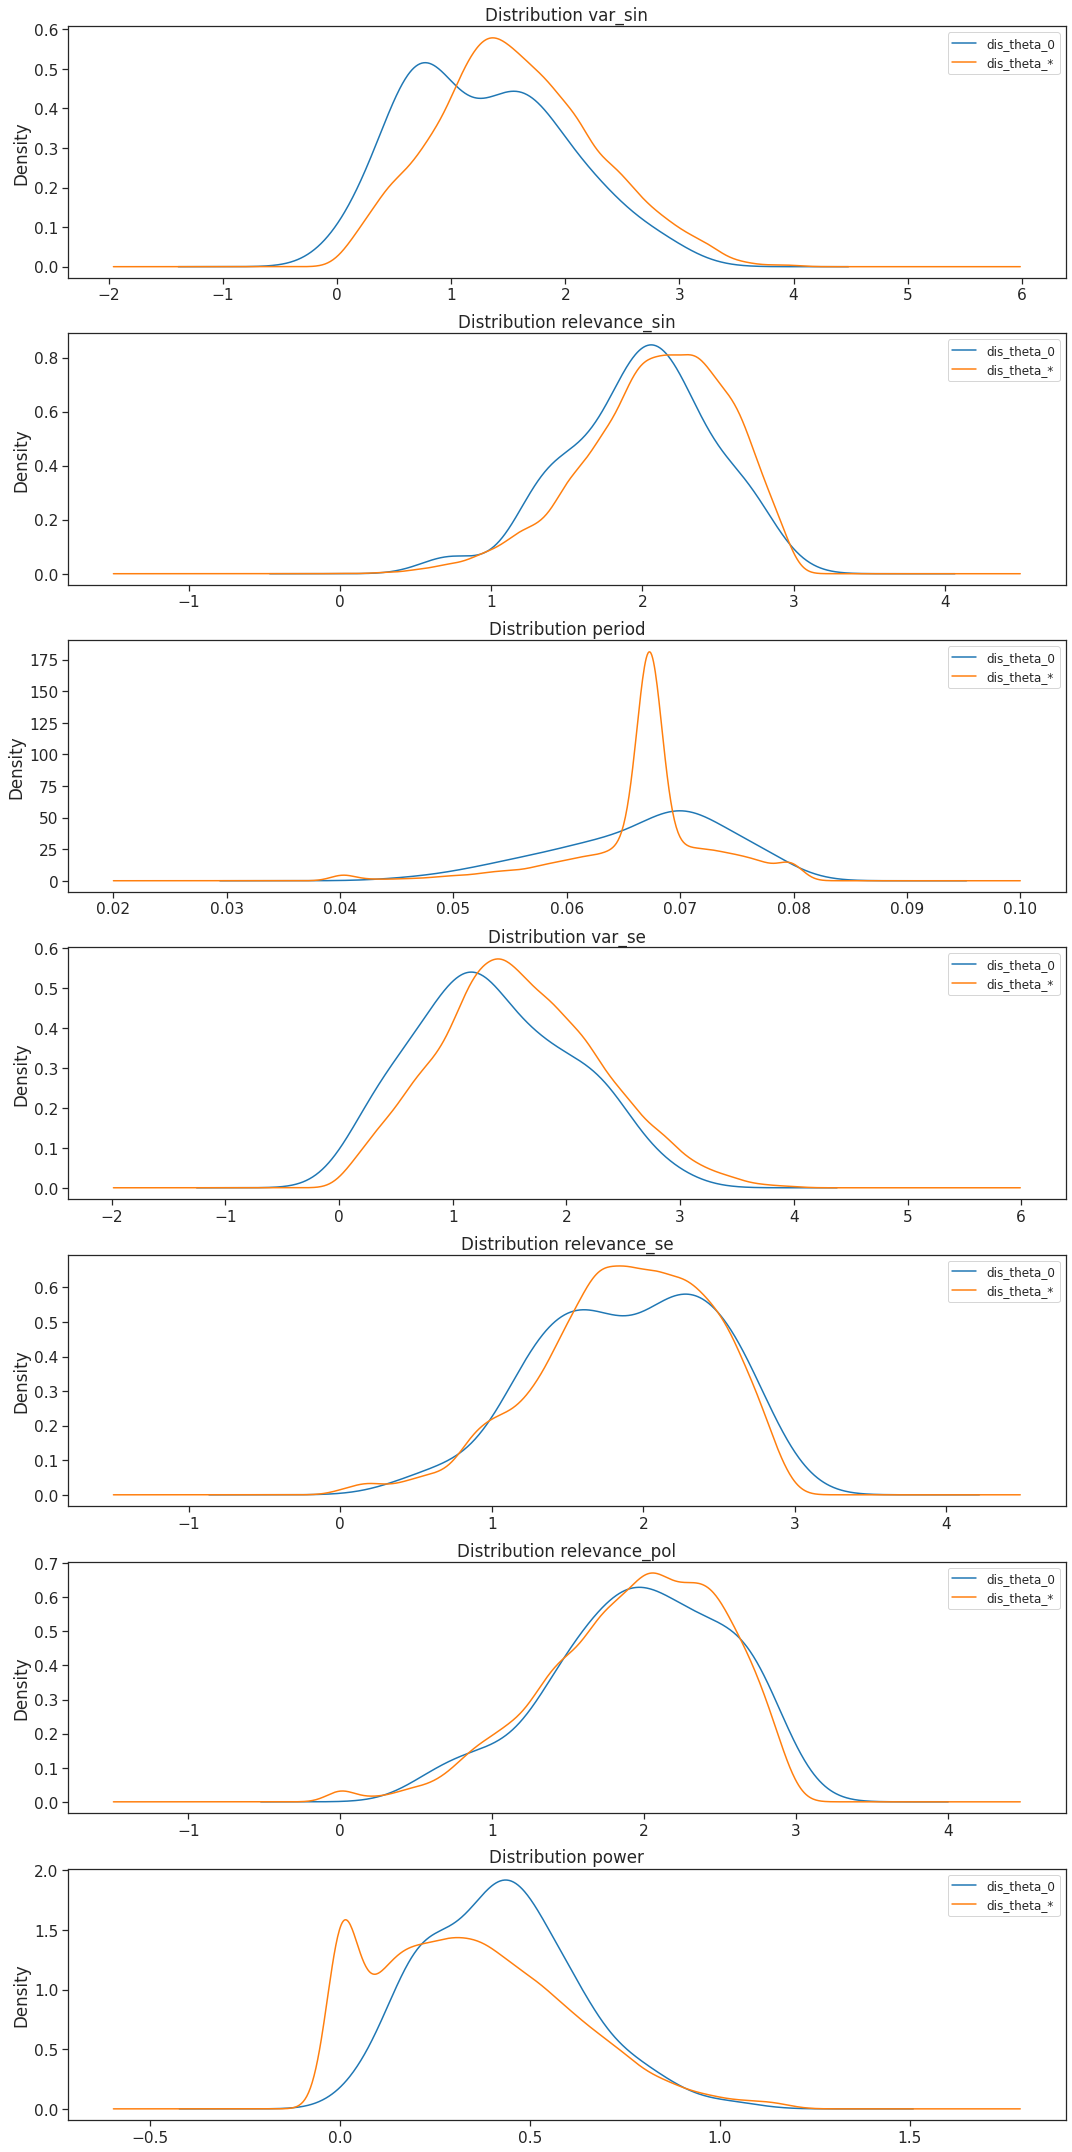

In [23]:
fig, ax = plt.subplots(len(tgp.priors.items()),1 ,figsize=(15, 30), squeeze=False)

keys = tgp.priors.keys()
for key in enumerate(keys):
    df_prior[key[1]].plot(kind='density',ax=ax[key[0]][0],label='dis_theta_0')
    df_theta[key[1]].plot(kind='density',ax=ax[key[0]][0],label='dis_theta_*') #theta_*
    #df_prior[key[1]].hist(density = True, ax=ax[key[0]][0], label='dis_theta_0')
    #df_theta[key[1]].hist(density = True, ax=ax[key[0]][0], label='dis_theta_*')
    ax[key[0]][0].set_title('Distribution '+ key[1])
    fig.tight_layout()
            

    ax[key[0]][0].legend(fontsize=12)

### si no fuera por el periodo tamos cerquita

## Wasserstein distance

It.  |Err         
-------------------
    0|2.262515e+00|
   10|1.514739e+00|
   20|1.376115e+00|
   30|1.320328e+00|
   40|1.295901e+00|
   50|1.285891e+00|
   60|1.282718e+00|
   70|1.282563e+00|
   80|1.283575e+00|
   90|1.284899e+00|
  100|1.286174e+00|
  110|1.287274e+00|
  120|1.288176e+00|
  130|1.288902e+00|
  140|1.289485e+00|
  150|1.289959e+00|
  160|1.290350e+00|
  170|1.290681e+00|
  180|1.290967e+00|
  190|1.291221e+00|
It.  |Err         
-------------------
  200|1.291449e+00|
  210|1.291657e+00|
  220|1.291849e+00|
  230|1.292027e+00|
  240|1.292193e+00|
  250|1.292347e+00|
  260|1.292490e+00|
  270|1.292623e+00|
  280|1.292747e+00|
  290|1.292862e+00|
  300|1.292967e+00|
  310|1.293065e+00|
  320|1.293154e+00|
  330|1.293236e+00|
  340|1.293312e+00|
  350|1.293380e+00|
  360|1.293443e+00|
  370|1.293500e+00|
  380|1.293552e+00|
  390|1.293599e+00|
It.  |Err         
-------------------
  400|1.293642e+00|
  410|1.293681e+00|
  420|1.293716e+00|
  430|1.293747e+00|
  4

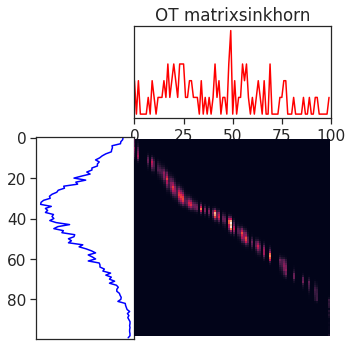

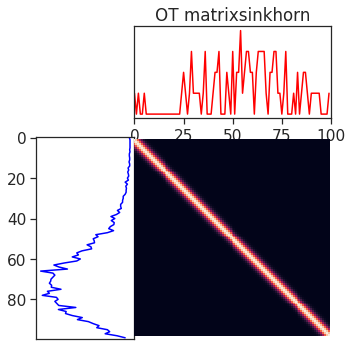

It.  |Err         
-------------------
    0|3.938808e+02|
   10|1.567311e+02|
   20|1.239082e+02|
   30|1.053209e+02|
   40|9.415981e+01|
   50|8.755904e+01|
   60|8.372711e+01|
   70|8.149284e+01|
   80|8.017455e+01|
   90|7.938881e+01|
  100|7.892109e+01|
  110|7.865018e+01|
  120|7.850831e+01|
  130|7.845440e+01|
  140|7.845816e+01|
  150|7.850295e+01|
  160|7.858186e+01|
  170|7.868649e+01|
  180|7.880701e+01|
  190|7.893501e+01|
It.  |Err         
-------------------
  200|7.906435e+01|
  210|7.919163e+01|
  220|7.931754e+01|
  230|7.944357e+01|
  240|7.956942e+01|
  250|7.969351e+01|
  260|7.981407e+01|
  270|7.992973e+01|
  280|8.003963e+01|
  290|8.014343e+01|
  300|8.024107e+01|
  310|8.033263e+01|
  320|8.041828e+01|
  330|8.049816e+01|
  340|8.057244e+01|
  350|8.064130e+01|
  360|8.070496e+01|
  370|8.076365e+01|
  380|8.081764e+01|
  390|8.086721e+01|
It.  |Err         
-------------------
  400|8.091263e+01|
  410|8.095420e+01|
  420|8.099219e+01|
  430|8.102689e+01|
  4

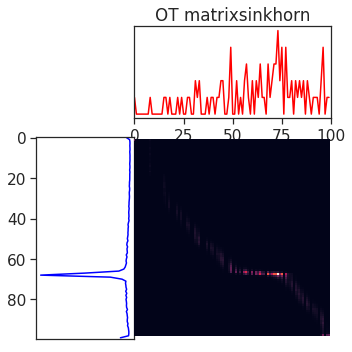

It.  |Err         
-------------------
    0|1.993786e+00|
   10|1.667432e+00|
   20|1.572504e+00|
   30|1.516738e+00|
   40|1.485419e+00|
   50|1.467845e+00|
   60|1.458242e+00|
   70|1.453035e+00|
   80|1.450123e+00|
   90|1.448368e+00|
  100|1.447171e+00|
  110|1.446234e+00|
  120|1.445421e+00|
  130|1.444674e+00|
  140|1.443973e+00|
  150|1.443317e+00|
  160|1.442707e+00|
  170|1.442146e+00|
  180|1.441635e+00|
  190|1.441174e+00|
It.  |Err         
-------------------
  200|1.440762e+00|
  210|1.440396e+00|
  220|1.440072e+00|
  230|1.439787e+00|
  240|1.439537e+00|
  250|1.439318e+00|
  260|1.439127e+00|
  270|1.438960e+00|
  280|1.438815e+00|
  290|1.438688e+00|
  300|1.438577e+00|
  310|1.438481e+00|
  320|1.438397e+00|
  330|1.438323e+00|
  340|1.438259e+00|
  350|1.438202e+00|
  360|1.438153e+00|
  370|1.438109e+00|
  380|1.438071e+00|
  390|1.438038e+00|
It.  |Err         
-------------------
  400|1.438008e+00|
  410|1.437982e+00|
  420|1.437959e+00|
  430|1.437939e+00|
  4

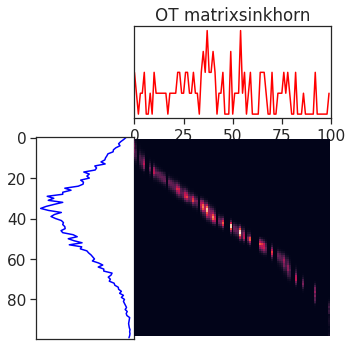

It.  |Err         
-------------------
    0|1.960105e+00|
   10|1.304835e+00|
   20|1.123022e+00|
   30|1.027670e+00|
   40|9.722398e-01|
   50|9.362157e-01|
   60|9.104743e-01|
   70|8.908861e-01|
   80|8.754723e-01|
   90|8.631776e-01|
  100|8.533511e-01|
  110|8.455293e-01|
  120|8.393476e-01|
  130|8.345044e-01|
  140|8.307482e-01|
  150|8.278696e-01|
  160|8.256955e-01|
  170|8.240837e-01|
  180|8.229177e-01|
  190|8.221022e-01|
It.  |Err         
-------------------
  200|8.215599e-01|
  210|8.212284e-01|
  220|8.210573e-01|
  230|8.210068e-01|
  240|8.210453e-01|
  250|8.211478e-01|
  260|8.212950e-01|
  270|8.214718e-01|
  280|8.216668e-01|
  290|8.218712e-01|
  300|8.220785e-01|
  310|8.222839e-01|
  320|8.224838e-01|
  330|8.226760e-01|
  340|8.228587e-01|
  350|8.230310e-01|
  360|8.231924e-01|
  370|8.233428e-01|
  380|8.234821e-01|
  390|8.236108e-01|
It.  |Err         
-------------------
  400|8.237291e-01|
  410|8.238377e-01|
  420|8.239371e-01|
  430|8.240279e-01|
  4

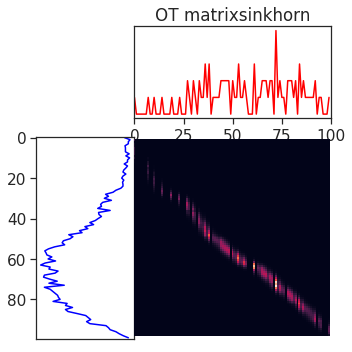

It.  |Err         
-------------------
    0|2.496085e+00|
   10|1.866509e+00|
   20|1.748351e+00|
   30|1.706369e+00|
   40|1.686276e+00|
   50|1.673209e+00|
   60|1.663643e+00|
   70|1.656204e+00|
   80|1.650407e+00|
   90|1.645781e+00|
  100|1.642150e+00|
  110|1.639473e+00|
  120|1.637637e+00|
  130|1.636517e+00|
  140|1.635988e+00|
  150|1.635929e+00|
  160|1.636242e+00|
  170|1.636845e+00|
  180|1.637666e+00|
  190|1.638646e+00|
It.  |Err         
-------------------
  200|1.639736e+00|
  210|1.640895e+00|
  220|1.642095e+00|
  230|1.643310e+00|
  240|1.644519e+00|
  250|1.645708e+00|
  260|1.646865e+00|
  270|1.647982e+00|
  280|1.649051e+00|
  290|1.650070e+00|
  300|1.651036e+00|
  310|1.651948e+00|
  320|1.652805e+00|
  330|1.653609e+00|
  340|1.654361e+00|
  350|1.655061e+00|
  360|1.655713e+00|
  370|1.656319e+00|
  380|1.656880e+00|
  390|1.657400e+00|
It.  |Err         
-------------------
  400|1.657880e+00|
  410|1.658323e+00|
  420|1.658733e+00|
  430|1.659109e+00|
  4

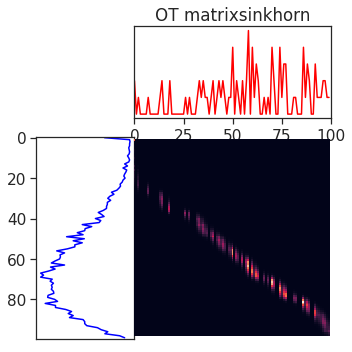

It.  |Err         
-------------------
    0|1.154332e+01|
   10|6.321378e+00|
   20|5.275344e+00|
   30|4.738001e+00|
   40|4.346563e+00|
   50|4.048329e+00|
   60|3.818482e+00|
   70|3.639901e+00|
   80|3.500553e+00|
   90|3.391891e+00|
  100|3.307505e+00|
  110|3.242322e+00|
  120|3.192219e+00|
  130|3.153911e+00|
  140|3.124848e+00|
  150|3.103010e+00|
  160|3.086758e+00|
  170|3.074821e+00|
  180|3.066243e+00|
  190|3.060277e+00|
It.  |Err         
-------------------
  200|3.056327e+00|
  210|3.053920e+00|
  220|3.052680e+00|
  230|3.052313e+00|
  240|3.052584e+00|
  250|3.053310e+00|
  260|3.054352e+00|
  270|3.055602e+00|
  280|3.056982e+00|
  290|3.058432e+00|
  300|3.059909e+00|
  310|3.061379e+00|
  320|3.062819e+00|
  330|3.064210e+00|
  340|3.065541e+00|
  350|3.066802e+00|
  360|3.067991e+00|
  370|3.069104e+00|
  380|3.070142e+00|
  390|3.071106e+00|
It.  |Err         
-------------------
  400|3.071998e+00|
  410|3.072821e+00|
  420|3.073578e+00|
  430|3.074274e+00|
  4

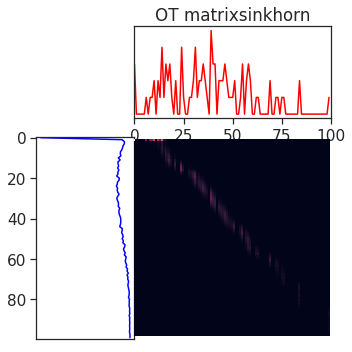

In [24]:
wasserstein_distance(df_theta,df_prior, n=100)